In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd '/content/drive/My Drive/House-price-forecast'

/content/drive/My Drive/House-price-forecast


### 1、导入所需的库

In [3]:
#基础
import numpy as np
import pandas as pd
import time

#绘图
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#模型
from sklearn.linear_model import Lasso, LassoCV, ElasticNet, ElasticNetCV, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.svm import SVR
import lightgbm as lgb
import xgboost as xgb

#模型相关
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

#忽略警告
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 2、读取数据集，对正偏斜的目标值取对数处理

In [4]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
print('The shape of training data:', train.shape)
print('The shape of testing data:', test.shape)

The shape of training data: (1458, 160)
The shape of testing data: (1459, 159)


In [5]:
train.isnull().sum().any()

False

Skewness of target: 1.8812964895244009
kurtosis of target: 6.523066888485879


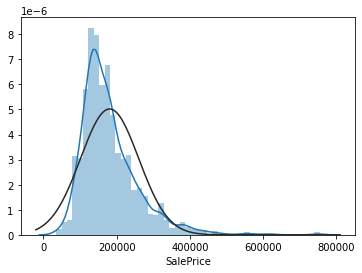

In [6]:
from scipy.stats import skew, kurtosis, norm

y = train['SalePrice']
print('Skewness of target:', y.skew())
print('kurtosis of target:', y.kurtosis())
sns.distplot(y, fit=norm);

可以看出，未处理的目标值明显右偏，不满足正态分布

Skewness of target: 0.12157976050304879
kurtosis of target: 0.8047507917418972


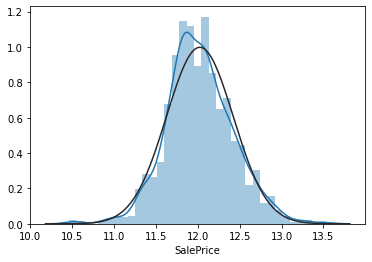

In [7]:
y = np.log1p(y)
print('Skewness of target:', y.skew())
print('kurtosis of target:', y.kurtosis())
sns.distplot(y, fit=norm);

处理后的目标值接近正态分布

In [8]:
train = train.drop('SalePrice', axis=1)

#检查训练集与测试集的维度是否一致
print('The shape of training data:', train.shape)
print('The length of y:', len(y))
print('The shape of testing data:', test.shape)

The shape of training data: (1458, 159)
The length of y: 1458
The shape of testing data: (1459, 159)


In [9]:
y.isnull().sum()

0

### 3、定义交叉验证策略及评估方法

In [10]:
#采用十折交叉验证
n_folds = 10

def rmse_cv(model):
  kf = KFold(n_folds, shuffle=True, random_state=20)
  rmse = np.sqrt(-cross_val_score(model, train.values, y, scoring='neg_mean_squared_error', cv=kf))
  return(rmse)

### 4、单个模型参数设置
采用六个模型：
* Lasso
* ElasticNet
* Ridge
* Gradient Boosting
* LightGBM
* XGBoost

In [11]:
#Lasso
lasso_alpha = [0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]
lasso = make_pipeline(RobustScaler(), LassoCV(alphas=lasso_alpha, random_state=2))

In [12]:
#ElasticNet
enet_beta = [0.1, 0.2, 0.5, 0.6, 0.8, 0.9]
enet_alpha = [0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01]
ENet = make_pipeline(RobustScaler(), ElasticNetCV(l1_ratio=enet_beta, alphas=enet_alpha, random_state=12))

In [13]:
#Ridge
rid_alpha = [0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]
rid = make_pipeline(RobustScaler(), RidgeCV(alphas=rid_alpha))

In [14]:
#Gradient Boosting
gbr_params = {'loss': 'huber',
      'criterion': 'mse', 
      'learning_rate': 0.1,
      'n_estimators': 600, 
      'max_depth': 4,
      'subsample': 0.6,
      'min_samples_split': 20,
      'min_samples_leaf': 5,
      'max_features': 0.6,
      'random_state': 32,
      'alpha': 0.5}
gbr = GradientBoostingRegressor(**gbr_params)

In [15]:
#LightGBM
lgbr_params = {'learning_rate': 0.01,
      'n_estimators': 1850, 
      'max_depth': 4,
      'num_leaves': 20,
      'subsample': 0.6,
      'colsample_bytree': 0.6,
      'min_child_weight': 0.001,
      'min_child_samples': 21,
      'random_state': 42,
      'reg_alpha': 0,
      'reg_lambda': 0.05}
lgbr = lgb.LGBMRegressor(**lgbr_params)

In [17]:
#XGBoost
xgbr_params = {'learning_rate': 0.01,
      'n_estimators': 3000, 
      'max_depth': 5,
      'subsample': 0.6,
      'colsample_bytree': 0.7,
      'min_child_weight': 3,
      'seed': 52,
      'gamma': 0,
      'reg_alpha': 0,
      'reg_lambda': 1}
xgbr = xgb.XGBRegressor(**xgbr_params)

### 5、单个模型评估

In [18]:
models_name = ['Lasso', 'ElasticNet', 'Ridge', 'Gradient Boosting', 'LightGBM', 'XGBoost']
models = [lasso, ENet, rid, gbr, lgbr, xgbr]
for i, model in enumerate(models):
  score = rmse_cv(model)
  print('{} score: {}({})'.format(models_name[i], score.mean(), score.std()))

Lasso score: 0.11068147519566576(0.0073942264704033155)
ElasticNet score: 0.11091904371233648(0.007532173448331412)
Ridge score: 0.11119303368441777(0.00758400106291327)
Gradient Boosting score: 0.11865538871859024(0.009497984510023386)
LightGBM score: 0.118318792967013(0.010364808635531306)
[14:54:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:54:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:54:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:55:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:55:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:56:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:

### 6、设置Stacking模型参数

In [19]:
stack_model = StackingCVRegressor(regressors=(lasso, ENet, rid, gbr, lgbr, xgbr), meta_regressor=lasso, use_features_in_secondary=True)

### 7、在整个训练集上训练各模型

In [20]:
#Lasso
lasso_trained = lasso.fit(np.array(train), np.array(y))

In [21]:
#ElasticNet
ENet_trained = ENet.fit(np.array(train), np.array(y))

In [22]:
#Ridge
rid_trained = rid.fit(np.array(train), np.array(y))

In [23]:
#Gradient Boosting
gbr_trained = gbr.fit(np.array(train), np.array(y))

In [24]:
#LightGBM
lgbr_trained = lgbr.fit(np.array(train), np.array(y))

In [25]:
#XGBoost
xgbr_trained = xgbr.fit(np.array(train), np.array(y))

[14:59:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [26]:
#Stacking
stack_model_trained = stack_model.fit(np.array(train), np.array(y))

[15:00:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:00:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:01:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:01:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:01:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:02:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### 8、评估各个模型在完整训练集上的表现

In [27]:
def rmse(y, y_preds):
  return np.sqrt(mean_squared_error(y, y_preds))

In [28]:
models.append(stack_model)
models_name.append('Stacking_model')
for i, model in enumerate(models):
  y_preds = model.predict(np.array(train))
  model_score = rmse(y, y_preds)
  print('RMSE of {}: {}'.format(models_name[i], model_score))

RMSE of Lasso: 0.0989275731446597
RMSE of ElasticNet: 0.09866027051143429
RMSE of Ridge: 0.09681908262749463
RMSE of Gradient Boosting: 0.06583064311955181
RMSE of LightGBM: 0.0641626832182992
RMSE of XGBoost: 0.02286417135304461
RMSE of Stacking_model: 0.09431153828814741


### 9、提交各个模型的预测结果

In [31]:
sample_submission = pd.read_csv('sample_submission.csv')
for i, model in enumerate(models):
  preds = model.predict(np.array(test))
  submission = pd.DataFrame({'Id': sample_submission['Id'], 'SalePrice': np.expm1(preds)})
  submission.to_csv('House_Price_submission_'+models_name[i]+'_optimation.csv', index=False)
  print('{} finished.'.format(models_name[i]))

Lasso finished.
ElasticNet finished.
Ridge finished.
Gradient Boosting finished.
LightGBM finished.
XGBoost finished.
Stacking_model finished.


### 10、均值融合

In [29]:
preds_in_train = np.zeros((len(y), len(models)))
for i, model in enumerate(models):
  preds_in_train[:, i] = model.predict(np.array(train))
average_preds_in_train = preds_in_train.mean(axis=1)

In [30]:
average_score = rmse(y, average_preds_in_train)
print('RMSE of average model on training data:', average_score)

RMSE of average model on training data: 0.07286858974899155


In [32]:
#提交均值融合预测结果
preds_in_test = np.zeros((len(test), len(models)))
for i, model in enumerate(models):
  preds_in_test[:, i] = model.predict(np.array(test))
average_preds_in_test = preds_in_test.mean(axis=1)

average_submission = pd.DataFrame({'Id': sample_submission['Id'], 'SalePrice': np.expm1(average_preds_in_test)})
average_submission.to_csv('House_Price_submission_average_model_optimation.csv', index=False)

### 11、权值融合

In [33]:
model_weights = [0.15, 0.12, 0.08, 0.08, 0.12, 0.15, 0.3]
weight_preds_in_train = np.matmul(preds_in_train, model_weights)

weight_score = rmse(y, weight_preds_in_train)
print('RMSE of weight model on training data:', weight_score)

RMSE of weight model on training data: 0.07525884061133567


In [34]:
#提交权值融合预测结果
weight_preds_in_test = np.matmul(preds_in_test, model_weights)

weight_submission = pd.DataFrame({'Id': sample_submission['Id'], 'SalePrice': np.expm1(weight_preds_in_test)})
weight_submission.to_csv('House_Price_submission_weight_model_optimation.csv', index=False)

#### 12、保存预测结果

In [35]:
#保存训练集上的预测结果
train_prediction = pd.DataFrame(preds_in_train, columns=models_name)
train_prediction.head()

,Lasso,ElasticNet,Ridge,Gradient Boosting,LightGBM,XGBoost,Stacking_model
0,12.243033,12.242942,12.243642,12.252759,12.205982,12.240190,12.247418
1,12.138067,12.140639,12.162185,12.108321,12.054906,12.098722,12.163911
2,12.263182,12.262274,12.261112,12.290725,12.262509,12.296590,12.275705
3,12.054507,12.053744,12.044724,11.960368,11.940389,11.873365,12.029737
4,12.576098,12.575636,12.573866,12.474674,12.522560,12.470411,12.533831


In [36]:
train_prediction.shape

(1458, 7)

In [37]:
train_prediction.to_csv('train_prediction_of_7_models.csv', index=False)

In [38]:
#保存测试集上的预测结果
test_prediction = pd.DataFrame(preds_in_test, columns=models_name)
test_prediction.head()

,Lasso,ElasticNet,Ridge,Gradient Boosting,LightGBM,XGBoost,Stacking_model
0,11.686103,11.689379,11.707030,11.727196,11.712525,11.732334,11.678234
1,11.938668,11.932496,11.929884,11.968118,11.957699,12.001780,11.933534
2,12.114848,12.115056,12.111930,12.121909,12.123789,12.155682,12.131703
3,12.188549,12.187790,12.178972,12.175942,12.166634,12.173287,12.194356
4,12.217765,12.219003,12.224793,12.113195,12.168493,12.098944,12.220582


In [39]:
test_prediction.shape

(1459, 7)

In [40]:
test_prediction.to_csv('test_prediction_of_7_models.csv', index=False)